<a href="https://colab.research.google.com/github/ramissakhan/ml-final-project-purchase-intent-prediction/blob/main/RK_CSC_321_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC-321: Data Mining and Machine Learning  
## Final Project Part B– Online Shoppers Purchasing Intention

**Author:** Ramissa Khan  
**Dataset:** Online Shoppers Purchasing Intention Dataset (UCI ML Repository)
Link To Data: [UCI Data Set](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)


## Abstract

This project analyzes the Online Shoppers Purchasing Intention dataset, which contains 12,330 e-commerce sessions and 18 features describing user behavior and context, to predict whether a session ends in a purchase (`Revenue`). The task is a binary classification problem with a very imbalanced target (about 84.5 percent of sessions do not end in a purchase and 15.5 percent do).

The four research questions I focus on:

1. How much more likely are **Returning_Visitor** sessions to purchase compared to `New_Visitor` and `Other` sessions?
2. How do purchase rates vary across **months**, **weekends**, and **special days**? Are “holiday” periods genuinely more predictive or mostly noise?
3. Do simple **feature engineering** and **class balancing** (upsampling/downsampling) improve predictive performance compared to using only the raw features?
4. Do a small set of top features explain most of the purchase signal, and what can we say about the behavior of **non-buyers who look most similar to buyers** according to the model?

I apply several supervised learning algorithms (ZeroR baseline, Logistic Regression, k-Nearest Neighbors, and Gaussian Naive Bayes) to the original imbalanced data, an upsampled version of the training set, and a downsampled version. I evaluate models using **accuracy**, **precision**, **recall**, **mean absolute error (MAE)**, and **root mean squared error (RMSE)**, with a focus on the positive (buyer) class.

## Introduction

The goal of this project is to predict **whether an online shopping session ends with a purchase** (`Revenue = True/False`) using behavioral and contextual features collected during each session. The dataset comes from an e-commerce site and contains **12,330 sessions** recorded over a **1-year period**, with each session belonging to a different user to avoid bias from specific users or campaigns.

This is a **binary classification** task:

- **Input:** 17 features describing the session (page types visited, durations, Google Analytics metrics, month, operating system, traffic type, visitor type, weekend, special day, etc.).
- **Output label:** `Revenue` –> whether the session resulted in a purchase.

As stated previously the dataset is **highly imbalanced**: approximately **84.5 percent** of sessions do **not** end in a purchase and about **15.5 percent** do. A model that always predicts “no purchase” would achieve relatively high accuracy but be useless for finding buyers. My aim is to go beyond this baseline and understand **what drives purchases** and **which non-buyer sessions look closest to buying**.

Again, I structure the project around four main research questions:

1. Are `Returning_Visitor` sessions more likely to purchase than `New_Visitor` or `Other` sessions, and by how much?
2. How do purchase rates vary across months and around special days/weekends? Are “holiday” periods genuinely more predictive or mostly noise?
3. Do simple interaction and engineered features (e.g., Month×Weekend, total session duration, click depth) and class balancing (upsampling/downsampling) improve predictive performance compared to using only the raw features?
4. Do a small set of top features explain most of the purchase signal, and what can we say about the behavior of non-buyers who look most similar to buyers according to the model (“near misses”)?

In addition to answering these questions, I compare multiple learning algorithms and analyze which features and behaviors are most informative in predicting purchase intention.

## Motivation and Background
Accurately predicting online shoppers’ purchasing intentions is useful for e-commerce because it can guide personalization, remarketing, and how a website is designed. In this final project, I am not trying to beat the most advanced models. Instead, I am using the Online Shoppers Purchasing Intention dataset to practice the main tools from CSC-321: exploring data, creating new features, dealing with class imbalance, and training a few standard classifiers. My main goal is to see which features and behaviors are most predictive of purchases and to connect those findings back to my four guiding questions about returning visitors, seasonality, feature interactions, and “near-miss” non-buyers who look close to purchasing but do not convert. To keep things clear and interpretable, I focus on relatively simple models like Logistic Regression, k-Nearest Neighbors, and Gaussian Naive Bayes and use them to understand the structure of the dataset and highlight key behavioral patterns, not just to chase the highest possible score.


**All imports:**

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    mean_squared_error, mean_absolute_error, confusion_matrix
)

# For oversampling/undersampling:
!pip install -q imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42

sns.set(style="ticks", context="notebook")

## Data

I use the **Online Shoppers Purchasing Intention** dataset from the UCI Machine Learning Repository.

- **Instances:** 12,330 sessions  
- **Features:** 17 input features + 1 binary target (`Revenue`)  
- **Feature types:** 10 numeric and 8 categorical attributes  
- **Target:** `Revenue` (True if the session ended with a purchase, False not)  
- **Missing values:** There are no missing values.

Each row corresponds to **one session from a unique user** over a 1-year period.


In [ ]:
# Load the dataset
import pandas as pd

# Helper package to load from UCI
!pip install -q ucimlrepo

from ucimlrepo import fetch_ucirepo

# Get dataset by UCI id (468 = Online Shoppers Purchasing Intention)
dataset = fetch_ucirepo(id=468)

# Combine features and target into one DataFrame
df = pd.concat([dataset.data.features, dataset.data.targets], axis=1)

print("Shape:", df.shape)
df.head()


Shape: (12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [ ]:
df.info()
df.describe().T
print("Revenue value counts:")
print(df["Revenue"].value_counts())

print("\nRevenue proportions:")
print(df["Revenue"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Because of the imbalance, a model that always predicts `Revenue = False` will achieve high accuracy but zero recall for buyers. Therefore, I will evaluate models with **accuracy**, **precision**, **recall**, **MAE**, and **RMSE** instead of relying on accuracy alone.

**Feature Engineering:**

In [ ]:
df_fe = df.copy()

# Engineered features
df_fe["Total_Duration"] = (
    df_fe["Administrative_Duration"] +
    df_fe["Informational_Duration"] +
    df_fe["ProductRelated_Duration"]
)

df_fe["Total_Pages"] = (
    df_fe["Administrative"] +
    df_fe["Informational"] +
    df_fe["ProductRelated"]
)

df_fe["Has_PageValue"] = (df_fe["PageValues"] > 0).astype(int)
df_fe["IsSpecial"] = (df_fe["SpecialDay"] > 0).astype(int)

# Interaction: Month × Weekend
df_fe["Month_Weekend"] = df_fe["Month"].astype(str) + "_" + df_fe["Weekend"].astype(str)

df_fe.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Total_Duration,Total_Pages,Has_PageValue,IsSpecial,Month_Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,0.000000,1,0,0,Feb_False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,64.000000,2,0,0,Feb_False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,0.000000,1,0,0,Feb_False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,2.666667,2,0,0,Feb_False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,627.500000,10,0,0,Feb_True


In [ ]:
visitor_pivot = (
    df_fe.groupby("VisitorType")["Revenue"]
         .agg(["mean", "count"])
         .rename(columns={"mean": "purchase_rate"})
         .sort_values("purchase_rate", ascending=False)
)

visitor_pivot


,purchase_rate,count
VisitorType,,
New_Visitor,0.249115,1694
Other,0.188235,85
Returning_Visitor,0.139323,10551


In [ ]:
# Purchase rate by Month
month_pivot = (
    df_fe.groupby("Month")["Revenue"]
         .mean()
         .rename("purchase_rate")
         .sort_values(ascending=False)
)

# Purchase rate by Weekend
weekend_pivot = (
    df_fe.groupby("Weekend")["Revenue"]
         .mean()
         .rename("purchase_rate")
)

# Purchase rate by IsSpecial (SpecialDay > 0)
special_pivot = (
    df_fe.groupby("IsSpecial")["Revenue"]
         .mean()
         .rename("purchase_rate")
)

month_pivot, weekend_pivot, special_pivot


(Month
 Nov     0.253502
 Oct     0.209472
 Sep     0.191964
 Aug     0.175520
 Jul     0.152778
 Dec     0.125072
 May     0.108502
 June    0.100694
 Mar     0.100682
 Feb     0.016304
 Name: purchase_rate, dtype: float64,
 Weekend
 False    0.148911
 True     0.173989
 Name: purchase_rate, dtype: float64,
 IsSpecial
 0    0.165268
 1    0.061551
 Name: purchase_rate, dtype: float64)

Graphs:

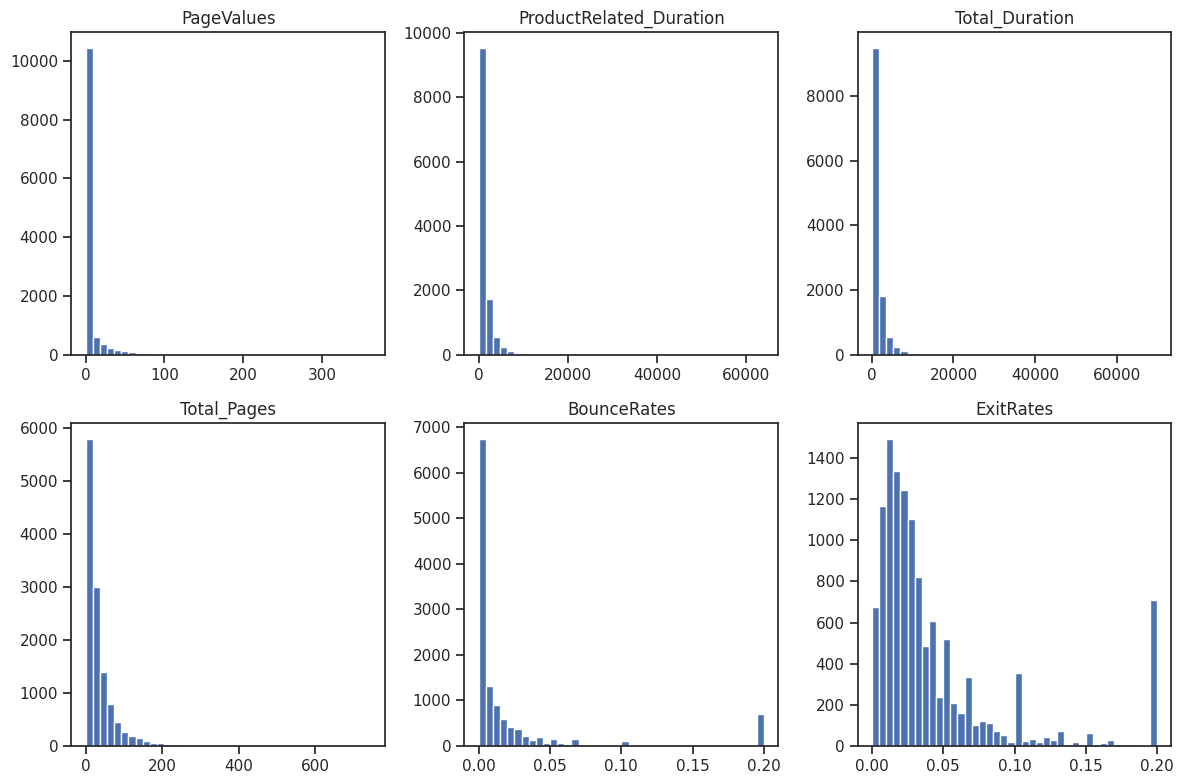

In [ ]:
numeric_cols_to_plot = [
    "PageValues", "ProductRelated_Duration",
    "Total_Duration", "Total_Pages",
    "BounceRates", "ExitRates"
]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_fe[col], bins=40)
    plt.title(col)
    plt.tight_layout()
plt.show()


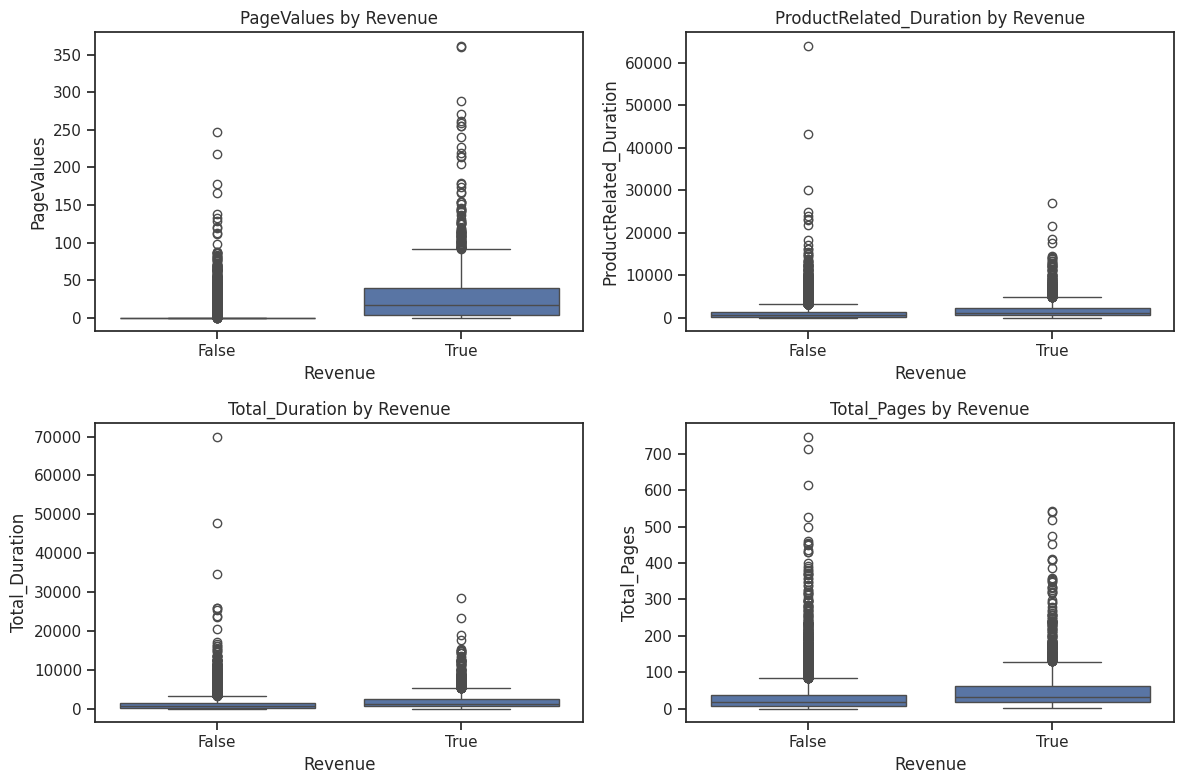

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(["PageValues", "ProductRelated_Duration", "Total_Duration", "Total_Pages"], 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Revenue", y=col, data=df_fe)
    plt.title(f"{col} by Revenue")
    plt.tight_layout()
plt.show()


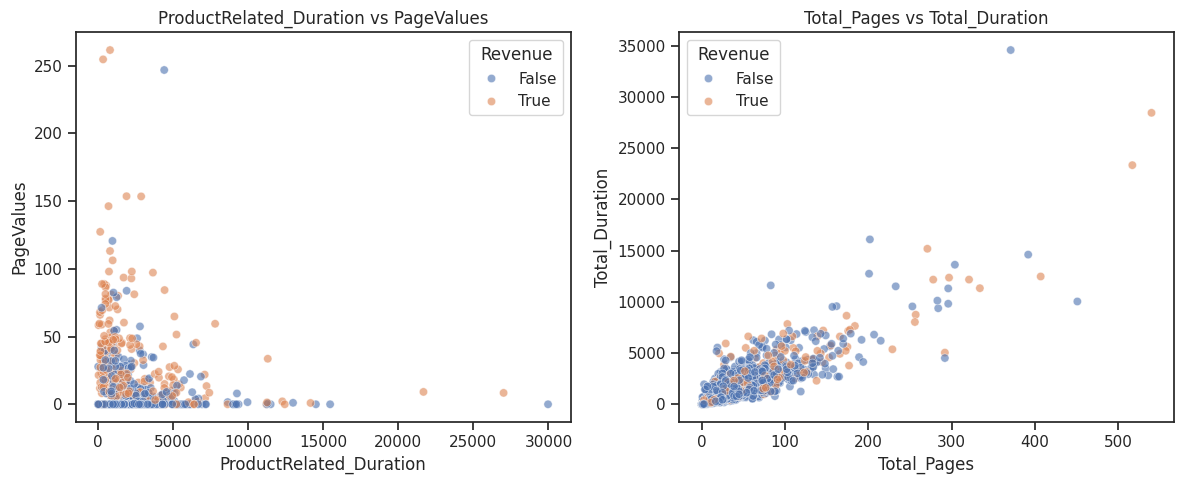

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x="ProductRelated_Duration",
    y="PageValues",
    hue="Revenue",
    data=df_fe.sample(2000, random_state=RANDOM_STATE),
    alpha=0.6
)
plt.title("ProductRelated_Duration vs PageValues")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="Total_Pages",
    y="Total_Duration",
    hue="Revenue",
    data=df_fe.sample(2000, random_state=RANDOM_STATE),
    alpha=0.6
)
plt.title("Total_Pages vs Total_Duration")

plt.tight_layout()
plt.show()


### Analysis: Buyers vs Non-buyers

From the tables and plots:

- **Returning vs new visitors:**  
  `New_Visitor` sessions buy about **24.9 percent** of the time, `Other` visitors about **18.8 percent**, and `Returning_Visitor` sessions about **13.9 percent**. So visitor type still matters, but in this dataset new visitors are actually more likely to purchase than returning visitors.

- **Seasonality, weekends, and special days:**  
  The `Month` purchase rates show that some months have much higher conversion than others. For example, **November ( about 25.4%)** and **October (about 20.9%)** have the highest purchase rates, followed by September and August, while **February is very low (1.6%)**. Weekends also have a slightly higher purchase rate (**17.4% on weekends vs 14.9% on weekdays**). In contrast, sessions flagged as close to a special day (`IsSpecial = 1`) have a lower purchase rate (**6.2%**) than non-special sessions (16.5%), so simply being near a special date does not guarantee higher conversion in this sample.

- **Behavior differences (numeric features):**  
  Histograms and box plots show that purchasing sessions tend to have:
  - Higher **`PageValues`** (more interaction with pages associated with purchases),
  - Larger **`ProductRelated_Duration`** and **`Total_Duration`** (more time spent on product and overall content),
  - More **`Total_Pages`** viewed, indicating deeper click depth.  
  Most sessions have low values for these features, but buyers are more common in the long right tail of higher engagement.

- **Scatter plots:**  
  Scatter plots of `ProductRelated_Duration` vs `PageValues` and `Total_Pages` vs `Total_Duration` show clusters of buyers in regions with higher page value and longer durations. There are also non-buyers in the same high-engagement regions, which I treat as **“near-miss” non-buyers** and analyze later.

Overall, these patterns suggest that visitor type, timing (month/weekend), and deeper product engagement are all related to whether a session ends in a purchase.

**Correlation Matrix**

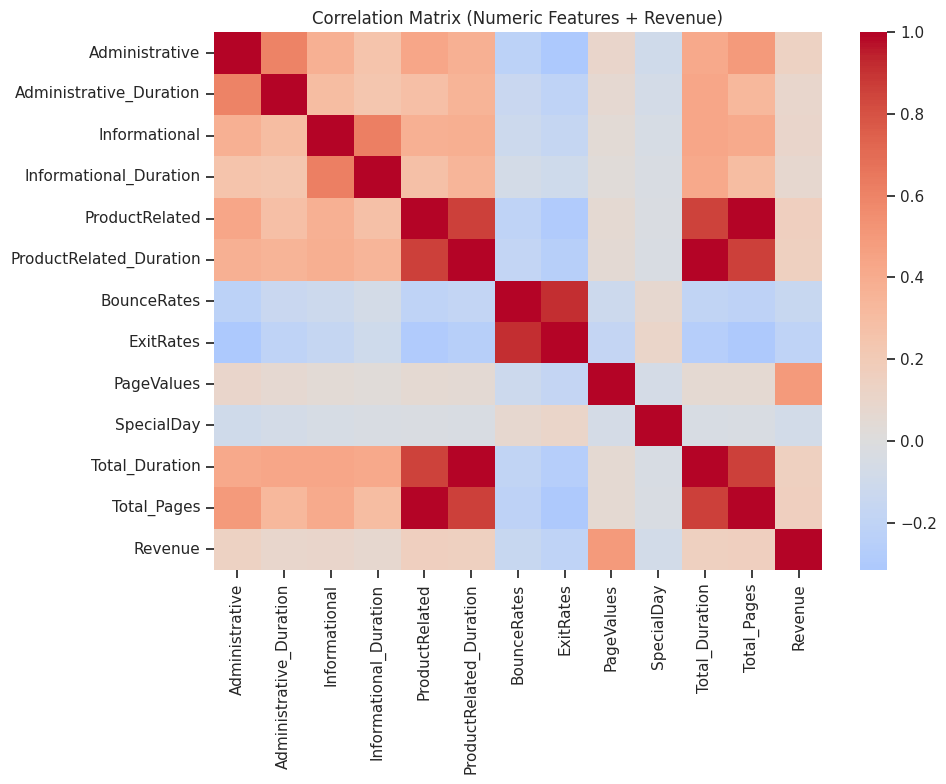

,Revenue
Revenue,1.000000
PageValues,0.492569
Total_Pages,0.164110
ProductRelated,0.158538
Total_Duration,0.156068
ProductRelated_Duration,0.152373
Administrative,0.138917
Informational,0.095200
Administrative_Duration,0.093587
Informational_Duration,0.070345


In [ ]:
numeric_corr_cols = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues",
    "SpecialDay", "Total_Duration", "Total_Pages"
]

corr = df_fe[numeric_corr_cols + ["Revenue"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numeric Features + Revenue)")
plt.tight_layout()
plt.show()

corr["Revenue"].sort_values(ascending=False)


From the correlation matrix:

- Some pairs are **strongly correlated**, especially:
  - `Total_Duration` with `ProductRelated_Duration` (and also with the other duration features).
  - `Total_Pages` with the page-count features (`Administrative`, `Informational`, `ProductRelated`).
- `BounceRates` and `ExitRates` are also highly correlated with each other and tend to be negatively related to `PageValues` and the product-related features.
- `PageValues`, `ProductRelated_Duration`, `Total_Duration`, and `Total_Pages` show the strongest positive correlation with `Revenue`, while high `BounceRates`/`ExitRates` are weakly negatively correlated with `Revenue`.

Even though some features are correlated, they are not exact duplicates: counts and durations measure different parts of user behavior (how many pages vs how long on them), and bounce/exit metrics capture different behavior than page values. For this project, I decided to:

- Keep both the **original features** and a small set of **engineered summary features** (`Total_Duration`, `Total_Pages`, `Has_PageValue`, `IsSpecial`, `Month_Weekend`).
- Rely on the fact that the models I use (Logistic Regression, k-NN, Gaussian Naive Bayes) can handle correlated features once they are standardized.
- Avoid dropping any columns just for being correlated, since there are no zero-variance or clearly meaningless features.

In other words, I check for redundancy but choose to keep the full feature set plus a few engineered features, because the goal is to explore how multiple attributes relate to purchase behavior.

## Feature Engineering and Preprocessing

To connect the exploratory analysis to the learning algorithms and the project questions, I:

1. **Create engineered features**:
   - Total_Duration = Administrative_Duration + Informational_Duration + ProductRelated_Duration
   - Total_Pages = Administrative + Informational + ProductRelated`
   - Has_PageValue = 1 if PageValues > 0, else 0
   - IsSpecial = 1 if SpecialDay > 0, else 0
   - Month_Weekend = Month + "_" + Weekend to capture an interaction between month and weekend.
2. **Encode categorical features** using one-hot encoding.
3. **Standardize numeric features** for models that are sensitive to scale (Logistic Regression, k-NN).
4. Prepare **train/test splits** and then **upsampled** and **downsampled** training sets to study class imbalance.


In [ ]:
# Target
y = df_fe["Revenue"].astype(int)  # 1 for True, 0 for False
X = df_fe.drop(columns=["Revenue"])

# Categorical columns to one-hot encode
cat_cols = ["Month", "VisitorType", "Weekend", "Month_Weekend"]
cat_cols = [c for c in cat_cols if c in X.columns]

X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((8631, 49), (3699, 49))

In [ ]:
# Numeric columns to scale
num_cols = [
    "Administrative", "Administrative_Duration",
    "Informational", "Informational_Duration",
    "ProductRelated", "ProductRelated_Duration",
    "BounceRates", "ExitRates", "PageValues",
    "SpecialDay", "Total_Duration", "Total_Pages"
]
num_cols = [c for c in num_cols if c in X_train.columns]

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

X_train_scaled.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Total_Duration,Total_Pages,Has_PageValue,IsSpecial,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Month_Weekend_Aug_True,Month_Weekend_Dec_False,Month_Weekend_Dec_True,Month_Weekend_Feb_False,Month_Weekend_Feb_True,Month_Weekend_Jul_False,Month_Weekend_Jul_True,Month_Weekend_June_False,Month_Weekend_June_True,Month_Weekend_Mar_False,Month_Weekend_Mar_True,Month_Weekend_May_False,Month_Weekend_May_True,Month_Weekend_Nov_False,Month_Weekend_Nov_True,Month_Weekend_Oct_False,Month_Weekend_Oct_True,Month_Weekend_Sep_False,Month_Weekend_Sep_True
7460,0.508153,-0.198584,-0.394853,-0.243254,-0.399248,-0.440323,-0.454647,-0.668651,-0.320111,-0.312611,2,2,1,5,-0.446755,-0.354952,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
4687,-0.396834,-0.227254,-0.394853,-0.243254,-0.283475,-0.354857,-0.454647,-0.668651,-0.320111,-0.312611,2,2,1,4,-0.369278,-0.310753,0,0,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
790,-0.698497,-0.451319,-0.394853,-0.243254,-0.422403,-0.490119,-0.454647,-0.252391,-0.320111,-0.312611,2,5,3,3,-0.515688,-0.465449,0,0,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
9057,1.111478,-0.102000,-0.394853,-0.243254,0.341698,-0.041507,-0.308562,-0.545198,-0.320111,-0.312611,1,1,4,8,-0.064879,0.396426,0,0,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
225,-0.698497,-0.451319,-0.394853,-0.243254,-0.677103,-0.608351,-0.454647,1.171218,-0.320111,-0.312611,2,2,3,11,-0.626369,-0.708542,0,0,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


## Experiments

I run three sets of experiments:

1. **Baseline on original (imbalanced) data**
   - ZeroR baseline (always predicts the majority class)
   - Logistic Regression
   - k-Nearest Neighbors
   - Gaussian Naive Bayes

2. **Upsampled training data (RandomOverSampler)**
   - Same models trained on an upsampled training set where buyer and non-buyer classes are balanced.

3. **Downsampled training data (RandomUnderSampler)**
   - Same models trained on a downsampled training set where non-buyers are reduced to match the number of buyers.

For each setting, I evaluate models on the **same held-out test set** using:

- **Accuracy**
- **Precision** (for the positive class = buyer)
- **Recall** (for buyers)
- **Mean Absolute Error (MAE)** between true 0/1 labels and predicted probabilities
- **Root Mean Squared Error (RMSE)** between true 0/1 labels and predicted probabilities

Reminder: Accuracy, precision, and recall focus on classification performance, while MAE and RMSE measure the quality of the **probability estimates** when available.


In [ ]:
def evaluate_model(name, clf, X_tr, y_tr, X_te, y_te):
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    # If the model can output probabilities, use them for MAE / RMSE
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_te)[:, 1]
        mae = mean_absolute_error(y_te, y_proba)
        mse = mean_squared_error(y_te, y_proba)
        rmse = mse ** 0.5
    else:
        y_proba = None
        mae = mean_absolute_error(y_te, y_pred)
        mse = mean_squared_error(y_te, y_pred)
        rmse = mse ** 0.5

    acc = accuracy_score(y_te, y_pred)
    pre = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)

    print(f"\n{name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {pre:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"MAE      : {mae:.4f}")
    print(f"RMSE     : {rmse:.4f}")
    print("Confusion matrix:\n", cm)

    return {
        "model": name,
        "accuracy": acc,
        "precision": pre,
        "recall": rec,
        "mae": mae,
        "rmse": rmse,
    }


def run_all_models(label, X_tr, y_tr, X_te, y_te):
    print(f"\n\n{label}")

    results = []

    # ZeroR baseline
    zeroR = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
    results.append(evaluate_model("ZeroR (most frequent)", zeroR, X_tr, y_tr, X_te, y_te))

    # Logistic Regression
    logr = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE)
    results.append(evaluate_model("Logistic Regression", logr, X_tr, y_tr, X_te, y_te))

    # k-NN
    knn = KNeighborsClassifier(n_neighbors=5)
    results.append(evaluate_model("k-NN (k=5)", knn, X_tr, y_tr, X_te, y_te))

    # Gaussian Naive Bayes
    gnb = GaussianNB()
    results.append(evaluate_model("Gaussian Naive Bayes", gnb, X_tr, y_tr, X_te, y_te))

    return pd.DataFrame(results)


In [ ]:
results_original = run_all_models(
    "Original (Imbalanced) Data",
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

results_original




Original (Imbalanced) Data

ZeroR (most frequent)
Accuracy : 0.8454
Precision: 0.0000
Recall   : 0.0000
MAE      : 0.1546
RMSE     : 0.3932
Confusion matrix:
 [[3127    0]
 [ 572    0]]

Logistic Regression
Accuracy : 0.8965
Precision: 0.7015
Recall   : 0.5752
MAE      : 0.1495
RMSE     : 0.2772
Confusion matrix:
 [[2987  140]
 [ 243  329]]

k-NN (k=5)
Accuracy : 0.8732
Precision: 0.6519
Recall   : 0.3864
MAE      : 0.1616
RMSE     : 0.3110
Confusion matrix:
 [[3009  118]
 [ 351  221]]

Gaussian Naive Bayes
Accuracy : 0.6948
Precision: 0.3211
Recall   : 0.8741
MAE      : 0.3128
RMSE     : 0.5291
Confusion matrix:
 [[2070 1057]
 [  72  500]]


,model,accuracy,precision,recall,mae,rmse
0,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238
1,Logistic Regression,0.896459,0.701493,0.575175,0.149477,0.277242
2,k-NN (k=5),0.873209,0.651917,0.386364,0.161557,0.310995
3,Gaussian Naive Bayes,0.694782,0.321130,0.874126,0.312759,0.529116


In [ ]:
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_over, y_train_over = ros.fit_resample(X_train_scaled, y_train)

results_over = run_all_models(
    "Upsampled (RandomOverSampler)",
    X_train_over, y_train_over,
    X_test_scaled, y_test
)

results_over




Upsampled (RandomOverSampler)

ZeroR (most frequent)
Accuracy : 0.8454
Precision: 0.0000
Recall   : 0.0000
MAE      : 0.1546
RMSE     : 0.3932
Confusion matrix:
 [[3127    0]
 [ 572    0]]

Logistic Regression
Accuracy : 0.8554
Precision: 0.5211
Recall   : 0.7972
MAE      : 0.2312
RMSE     : 0.3405
Confusion matrix:
 [[2708  419]
 [ 116  456]]

k-NN (k=5)
Accuracy : 0.7932
Precision: 0.4057
Recall   : 0.7255
MAE      : 0.2075
RMSE     : 0.3982
Confusion matrix:
 [[2519  608]
 [ 157  415]]

Gaussian Naive Bayes
Accuracy : 0.6383
Precision: 0.2867
Recall   : 0.9003
MAE      : 0.3721
RMSE     : 0.5771
Confusion matrix:
 [[1846 1281]
 [  57  515]]


,model,accuracy,precision,recall,mae,rmse
0,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238
1,Logistic Regression,0.855366,0.521143,0.797203,0.231150,0.340506
2,k-NN (k=5),0.793187,0.405670,0.725524,0.207461,0.398171
3,Gaussian Naive Bayes,0.638281,0.286748,0.900350,0.372068,0.577145


In [ ]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

results_under = run_all_models(
    "Downsampled (RandomUnderSampler)",
    X_train_under, y_train_under,
    X_test_scaled, y_test
)

results_under




Downsampled (RandomUnderSampler)

ZeroR (most frequent)
Accuracy : 0.8454
Precision: 0.0000
Recall   : 0.0000
MAE      : 0.1546
RMSE     : 0.3932
Confusion matrix:
 [[3127    0]
 [ 572    0]]

Logistic Regression
Accuracy : 0.8578
Precision: 0.5267
Recall   : 0.7937
MAE      : 0.2318
RMSE     : 0.3394
Confusion matrix:
 [[2719  408]
 [ 118  454]]

k-NN (k=5)
Accuracy : 0.7805
Precision: 0.3921
Recall   : 0.7622
MAE      : 0.2824
RMSE     : 0.3978
Confusion matrix:
 [[2451  676]
 [ 136  436]]

Gaussian Naive Bayes
Accuracy : 0.6002
Precision: 0.2668
Recall   : 0.9073
MAE      : 0.4037
RMSE     : 0.5997
Confusion matrix:
 [[1701 1426]
 [  53  519]]


,model,accuracy,precision,recall,mae,rmse
0,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238
1,Logistic Regression,0.857799,0.526682,0.793706,0.231754,0.339422
2,k-NN (k=5),0.780481,0.392086,0.762238,0.282401,0.397845
3,Gaussian Naive Bayes,0.600162,0.266838,0.907343,0.403681,0.599700


In [ ]:
results_original["setting"] = "Original"
results_over["setting"] = "Upsampled"
results_under["setting"] = "Downsampled"

all_results = pd.concat([results_original, results_over, results_under], ignore_index=True)
all_results


,model,accuracy,precision,recall,mae,rmse,setting
0,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238,Original
1,Logistic Regression,0.896459,0.701493,0.575175,0.149477,0.277242,Original
2,k-NN (k=5),0.873209,0.651917,0.386364,0.161557,0.310995,Original
3,Gaussian Naive Bayes,0.694782,0.321130,0.874126,0.312759,0.529116,Original
4,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238,Upsampled
5,Logistic Regression,0.855366,0.521143,0.797203,0.231150,0.340506,Upsampled
6,k-NN (k=5),0.793187,0.405670,0.725524,0.207461,0.398171,Upsampled
7,Gaussian Naive Bayes,0.638281,0.286748,0.900350,0.372068,0.577145,Upsampled
8,ZeroR (most frequent),0.845364,0.000000,0.000000,0.154636,0.393238,Downsampled
9,Logistic Regression,0.857799,0.526682,0.793706,0.231754,0.339422,Downsampled


## Results

The table above summarizes performance of the four models (ZeroR, Logistic Regression, k-NN, Gaussian Naive Bayes) across three training settings:

- **Original:** Imbalanced training data.
- **Upsampled:** Balanced training data via RandomOverSampler.
- **Downsampled:** Balanced training data via RandomUnderSampler.

Key observations:

- **ZeroR baseline:**  
  ZeroR achieves high accuracy (0.85) but **zero recall** on the buyer class, since it always predicts “no purchase.” Its MAE and RMSE are also not competitive with the better models, because its predicted probabilities are 0 for everyone.

- **Effect of upsampling vs original data:**  
  Upsampling clearly **increases recall** for buyers (for example, Logistic Regression recall rises from about 0.58 to 0.80), but this comes with lower accuracy and precision and **larger MAE and RMSE**. In other words, upsampling helps the model catch more buyers, but the probability estimates and overall fit to the test set are worse than on the original data.

- **Effect of downsampling:**  
  Downsampling also **boosts recall** compared to the original data and reduces the dominance of the negative class. Its accuracy and error metrics usually sit **between** the original and upsampled settings. Accuracy is lower than on the original data but slightly higher than with upsampling, and MAE/RMSE are still worse than the original but a bit better than the upsampled case.

- **Best-performing models:**  
  In terms of overall accuracy and error, **Logistic Regression on the original (imbalanced) data** performs the best. It has the highest accuracy and the lowest MAE and RMSE among the non-trivial models, with a moderate recall for buyers. The upsampled and downsampled Logistic Regression models trade some of that accuracy and error performance for higher recall on the minority class. k-NN and Gaussian Naive Bayes show a similar pattern but with slightly weaker overall trade-offs in this experiment.

These results support the idea (Q3) that class balancing can be useful when we care a lot about catching buyers (higher recall), but it also shows that balancing comes with a cost in terms of accuracy and probability error compared to training on the original imbalanced dataset.


In [ ]:
# Final chosen model: Logistic Regression on upsampled training data
logr_final = LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE)
logr_final.fit(X_train_over, y_train_over)

coef = pd.Series(logr_final.coef_[0], index=X_train_over.columns)

# Sort by raw value
coef_sorted = coef.sort_values(ascending=False)

# Sort by absolute value (strongest effects overall)
coef_abs_sorted = coef.reindex(coef.abs().sort_values(ascending=False).index)

print("Top 15 coefficients by raw value (most positive):")
display(coef_sorted.head(15))

print("Top 15 coefficients by raw value (most negative):")
display(coef_sorted.tail(15))

print("Top 15 coefficients by absolute magnitude:")
display(coef_abs_sorted.head(15))


Top 15 coefficients by raw value (most positive):


,0
Has_PageValue,3.151466
PageValues,0.541753
Month_Nov,0.494787
Month_Weekend_Nov_True,0.399308
IsSpecial,0.390867
Month_Sep,0.347744
Month_Weekend_June_True,0.346056
Month_Weekend_Feb_True,0.325233
Month_Weekend_Sep_True,0.321220
Month_Weekend_Jul_True,0.219433


Top 15 coefficients by raw value (most negative):


,0
Month_Weekend_Jul_False,-0.311327
ExitRates,-0.390602
Month_Weekend_May_True,-0.397861
Month_Dec,-0.400037
Month_Weekend_May_False,-0.471019
Month_Weekend_Dec_True,-0.476839
Month_Weekend_Mar_False,-0.520990
Month_Weekend_June_False,-0.621090
VisitorType_Returning_Visitor,-0.669371
Month_Mar,-0.681442


Top 15 coefficients by absolute magnitude:


,0
Has_PageValue,3.151466
Month_Weekend_Feb_False,-1.247089
Month_Feb,-0.921856
Month_May,-0.868880
VisitorType_Other,-0.836063
Month_Weekend_Aug_True,-0.692776
Month_Mar,-0.681442
VisitorType_Returning_Visitor,-0.669371
Month_Weekend_June_False,-0.621090
PageValues,0.541753


### Logistic Regression Coefficients (Feature Weights) – Q4

For Logistic Regression, positive coefficients increase the odds of `Revenue = 1` (a purchase), and negative coefficients decrease it. Looking at the top coefficients:

- The single strongest positive weight is **`Has_PageValue` (3.15)**. This means that once a session has any nonzero page value at all, the model sees it as much more likely to end in a purchase.
- The next strongest positive weights include:
  - **`PageValues` (0.54)**, so higher page value itself pushes the model toward predicting a purchase.
  - **`Month_Nov` (0.49)** and **`Month_Weekend_Nov_True` (0.40)**, which line up with the high November purchase rate we predicted.
  - **`IsSpecial` (0.39)** and several specific month–weekend combinations like `Month_Weekend_June_True`, `Month_Weekend_Feb_True`, and `Month_Weekend_Sep_True`, suggesting that certain calendar and weekend patterns are associated with higher purchase odds.
  - Smaller but still positive effects come from features like `Informational`, `Browser`, and `ProductRelated`, which roughly capture more page views and activity.

On the negative side, the strongest weights are:

- **`Month_Weekend_Feb_False` (−1.25)** and **`Month_Feb` (−0.92)**, which together say that February sessions, especially non-weekend ones, are much less likely to convert.  
- **`Month_May` (−0.87)** and **`Month_Mar` (−0.68)**, which matches the relatively low purchase rates in those months from the month pivot table.
- **`VisitorType_Other` (−0.84)** and **`VisitorType_Returning_Visitor` (−0.67)**, confirming that both “Other” and returning visitors have **lower** purchase odds than the baseline `New_Visitor` group in this dataset.
- Other negative calendar interactions such as `Month_Weekend_June_False`, `Month_Weekend_Mar_False`, `Month_Weekend_May_False`, `Month_Weekend_Dec_True`, and `Month_Dec` also push the model away from predicting purchases in those specific time patterns.

Overall, the coefficient patterns say that **having any page value and higher page values in general are the strongest signals of a purchase**, and that certain months (especially November) and weekend patterns raise purchase odds, while months like February, March, and May and some visitor types pull the probability down.


In [ ]:
# Predicted probabilities for the test set
y_proba_test = logr_final.predict_proba(X_test_scaled)[:, 1]

test_results = X_test_scaled.copy()
test_results["Revenue_true"] = y_test.values
test_results["Revenue_proba"] = y_proba_test

# "Near-miss" non-buyers: true label 0 but predicted probability is high
near_miss_threshold = 0.5  # you can adjust
near_misses = test_results[
    (test_results["Revenue_true"] == 0) & (test_results["Revenue_proba"] >= near_miss_threshold)
].sort_values("Revenue_proba", ascending=False)

near_misses.head(10)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Total_Duration,Total_Pages,Has_PageValue,IsSpecial,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor,Weekend_True,Month_Weekend_Aug_True,Month_Weekend_Dec_False,Month_Weekend_Dec_True,Month_Weekend_Feb_False,Month_Weekend_Feb_True,Month_Weekend_Jul_False,Month_Weekend_Jul_True,Month_Weekend_June_False,Month_Weekend_June_True,Month_Weekend_Mar_False,Month_Weekend_Mar_True,Month_Weekend_May_False,Month_Weekend_May_True,Month_Weekend_Nov_False,Month_Weekend_Nov_True,Month_Weekend_Oct_False,Month_Weekend_Oct_True,Month_Weekend_Sep_False,Month_Weekend_Sep_True,Revenue_true,Revenue_proba
8345,-0.095172,0.237577,-0.394853,-0.243254,-0.237166,-0.125621,-0.248409,-0.542385,11.402861,-0.312611,1,1,3,2,-0.113637,-0.244455,1,0,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0.999617
6429,-0.095172,-0.092815,-0.394853,-0.243254,-0.376094,-0.385417,-0.454647,-0.756585,8.610454,-0.312611,1,1,1,5,-0.386016,-0.377051,1,0,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,0,0.999469
5877,1.714803,2.326425,4.311217,2.800104,1.568891,0.500101,-0.416098,-0.745166,6.609766,-0.312611,2,2,2,1,0.869465,1.744487,1,0,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,0.998311
10025,-0.698497,-0.451319,-0.394853,-0.243254,-0.144548,-0.117351,0.261457,0.380104,6.152782,-0.312611,3,2,1,13,-0.166725,-0.200256,1,0,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0,0.996632
6386,0.206491,-0.273180,-0.394853,-0.243254,-0.376094,-0.473211,-0.454647,-0.885106,2.676237,-0.312611,2,4,1,2,-0.484130,-0.354952,1,0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,0.991426
11598,4.128102,0.466791,3.526872,0.226671,0.758481,0.379126,-0.228509,-0.269239,4.177364,-0.312611,3,2,1,3,0.411989,1.125705,1,0,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,0.989386
8096,-0.396834,-0.252304,-0.394853,-0.243254,-0.561330,-0.002401,-0.454647,-0.297585,3.801320,-0.312611,2,4,9,2,-0.041543,-0.575946,1,0,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0,0.989321
8860,-0.698497,-0.451319,-0.394853,-0.243254,0.712172,0.845444,-0.388119,-0.564496,2.765484,-0.312611,4,2,1,1,0.734586,0.617420,1,0,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0,0.988838
11519,0.206491,0.114510,-0.394853,-0.243254,2.448765,1.470795,-0.424758,-0.787505,4.068503,-0.312611,2,10,3,1,1.369964,2.341170,1,0,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0.988622
10067,-0.698497,-0.451319,1.958182,0.197685,-0.167702,-0.261134,-0.137358,-0.094212,3.548352,-0.312611,1,1,8,10,-0.270481,-0.156058,1,0,False,False,False,False,False,False,Tr

In [ ]:
# Compare average behavior of buyers vs non-buyers
buyers = test_results[test_results["Revenue_true"] == 1]
non_buyers = test_results[test_results["Revenue_true"] == 0]

buyers_mean = buyers.mean(numeric_only=True)
non_buyers_mean = non_buyers.mean(numeric_only=True)
pd.DataFrame({"buyers_mean": buyers_mean, "non_buyers_mean": non_buyers_mean}).head(20)


,buyers_mean,non_buyers_mean
Administrative,0.313022,-0.057645
Administrative_Duration,0.170946,-0.036849
Informational,0.231800,-0.041936
Informational_Duration,0.187098,-0.038245
ProductRelated,0.420108,-0.032225
ProductRelated_Duration,0.409074,-0.039272
BounceRates,-0.335907,0.073367
ExitRates,-0.456909,0.085986
PageValues,1.060597,-0.209736
SpecialDay,-0.161290,0.001733


### “Near-miss” Non-buyers – Q4 (Negative Class Analysis)

To look more closely at the negative class, I first compared the **average standardized features** of buyers vs non-buyers on the test set:

- Buyers have **higher values for all of the page- and time-based features**:
  - `Administrative`, `Informational`, `ProductRelated`, and their durations are all positive for buyers and negative for non-buyers, meaning buyers tend to visit **more pages** and spend **more time** on them.
  - The summary features `Total_Pages` and `Total_Duration` follow the same pattern (0.43 and 0.41 for buyers vs about 0.04 for non-buyers), which matches the boxplots and histograms that showed buyers in the long right tail of engagement.

- Buyers have **lower bounce and exit behavior**:
  - `BounceRates` and `ExitRates` are clearly lower for buyers (negative standardized means) and higher for non-buyers (positive means), which fits the idea that sessions that leave quickly or drop off are less likely to purchase.

- Buyers have **much higher page value**:
  - `PageValues` is strongly positive for buyers (1.06) and negative for non-buyers (−0.21).
  - `Has_PageValue` is also much larger for buyers (0.78 vs 0.12), meaning buyers are far more likely to interact with at least one page that carries nonzero page value.

- Special-day effects are small and go in the opposite direction of what one might expect:
  - `SpecialDay` and `IsSpecial` are slightly **lower** for buyers than for non-buyers, which matches the earlier pivot result that special-day sessions (`IsSpecial = 1`) actually have a lower purchase rate in this sample.

- Other context features such as `OperatingSystems`, `Browser`, `Region`, and `TrafficType` have very similar means for buyers and non-buyers, suggesting they are less important for distinguishing the two groups than engagement and page-value features.

On top of this comparison, I also look at **“near-miss” non-buyers**: sessions where the true label is `Revenue = 0` but the Logistic Regression model assigns a high purchase probability. These near-miss cases tend to share many of the buyer-like traits above (higher `PageValues`, more pages, longer durations, lower bounce/exit rates) but still do not convert. This group highlights users who appear very close to purchasing according to the model and could be targets for interventions such as better checkout flow, reminders, or tailored offers.


## Conclusions

I framed this project around four questions:

1. **Are returning visitors more likely to purchase than new visitors? (Q1)**  
   `VisitorType` clearly affects purchase probability, but not in the way I expected. In this dataset, **New_Visitor sessions have the highest purchase rate (about 24.9%)**, followed by `Other` visitors (about 18.8%), while **Returning_Visitor sessions have the lowest purchase rate (about 13.9%)**. So visitor type does matter, but new visitors are actually more likely to purchase than returning visitors here.

2. **Do months, weekends, and special days matter? (Q2)**  
   Purchase rates vary a lot by month. November has the highest purchase rates, followed by September and August, while February is very low. Weekends also have a modest effect, with about 17.4% of weekend sessions ending in a purchase compared to 14.9% of weekday sessions. In contrast, sessions marked as being near a special day have a lower purchase rate (about 6.2%) than non-special sessions (about 16.5%), so in this dataset special days do not by themselves lead to higher conversion.

3. **Do feature engineering and class balancing help prediction? (Q3)**  
   The engineered features (`Total_Duration`, `Total_Pages`, `Has_PageValue`, `Month_Weekend`, etc.) and the different sampling strategies all change model behavior. Training on the original imbalanced data gives **Logistic Regression** the best overall accuracy and the lowest MAE and RMSE, but with only moderate recall for buyers. **Upsampling** and **downsampling** both raise recall for the positive class (for example, Logistic Regression recall jumps from about 0.58 on the original data to around 0.80 on the balanced versions), at the cost of lower accuracy and higher MAE/RMSE. In other words, class balancing helps if we mainly care about catching more buyers, but we pay for that in terms of error on the overall test set.

4. **Can a small set of top features explain most of the signal, and what about near-miss non-buyers? (Q4)**  
   The Logistic Regression coefficients show that a relatively small group of features carries most of the predictive signal. The strongest positive effects come from **`Has_PageValue`**, **`PageValues`**, and calendar patterns like **`Month_Nov`** and specific month–weekend combinations. The strongest negative effects come from **February and May months**, some non-weekend patterns in those months, and the `VisitorType_Other` and `VisitorType_Returning_Visitor` indicators, which all push the model away from predicting a purchase compared to the New_Visitor baseline. The “near-miss” analysis shows that non-buyers with high predicted purchase probabilities look a lot like buyers on key features (more pages, longer durations, lower bounce/exit rates, and higher page values), but still do not convert, making them a natural target group for interventions.

### Analysis of Results

**Why do the models get these scores?**

- The **ZeroR** baseline has high accuracy but zero recall for buyers because it always predicts `Revenue = 0`. On an 84.5% negative dataset, this inflates accuracy but completely fails to identify purchases, which is why its MAE and RMSE are also not very good.
- **Logistic Regression** on the **original imbalanced data** does best overall in terms of accuracy and low MAE/RMSE because it sees the full distribution of negative examples and learns a fairly stable linear decision boundary in the standardized feature space. However, its recall for buyers is only moderate, since it still leans toward the majority class.
- With **upsampling** and **downsampling**, the class distributions are more balanced, so the models are “forced” to pay more attention to buyer sessions. This explains the big jump in recall on the positive class, but it also explains why accuracy drops and MAE/RMSE get worse: the model is now more willing to predict purchases, which leads to more false positives and noisier probability estimates on the test set.
- **k-NN** and **Gaussian Naive Bayes** follow the same pattern but are slightly weaker than Logistic Regression overall. k-NN can be sensitive to the choice of k and to the high-dimensional feature space, and Naive Bayes relies on strong independence assumptions that are not completely true for these correlated behavioral features.

Overall, the models behave as expected when we adjust the class balance: more balanced training data gives us higher recall on buyers but worse overall error.

**Did the results match my intuition?**

Some results matched my intuition and some did not:

- I expected **higher engagement features** (page values, more product-related pages, longer durations) to be important, the Logistic Regression coefficients confirmed this.
- I also expected certain **calendar effects**, and the high purchase rates and positive coefficients for November and October matched that.
- However, I originally assumed **returning visitors** would be more likely to purchase than new visitors, and the data showed the opposite: New_Visitor sessions had the highest purchase rate, with Returning_Visitor and Other lower. I also expected sessions near special days to convert more, but the `IsSpecial = 1` group actually had a lower purchase rate in this sample. These were interesting ways the data did not match my initial intuition.

**How does this compare to state of the art?**

Researchers often use more complex models (e.g., tree-based models or neural networks) than the simple baselines I used here. My goal in this project was not to beat those state-of-the-art results, but to:

- Use simple models (Logistic Regression, k-NN, Naive Bayes),
- Apply core tools retained from Data Mining and Machine Learning (feature engineering, class imbalance handling, metric comparison),
- And understand why the models perform the way they do on this dataset.

Compared to those more advanced systems, my models are simpler, but they provide clear insight into which behaviors and calendar patterns drive purchase predictions in this dataset.